
--- Disease Prediction (Random Forest) ---
Accuracy: 0.2972072072072072
              precision    recall  f1-score   support

           0       0.29      0.29      0.29      1915
           1       0.29      0.30      0.30      1847
           2       0.31      0.30      0.30      1871
           3       0.29      0.30      0.29      1822
           4       0.29      0.31      0.30      1788
           5       0.32      0.30      0.31      1857

    accuracy                           0.30     11100
   macro avg       0.30      0.30      0.30     11100
weighted avg       0.30      0.30      0.30     11100

AUC-ROC Score: 0.6186185188659749

--- Patient Risk Clustering (K-Means) ---
Silhouette Score: 0.239
Davies-Bouldin Index: 1.332


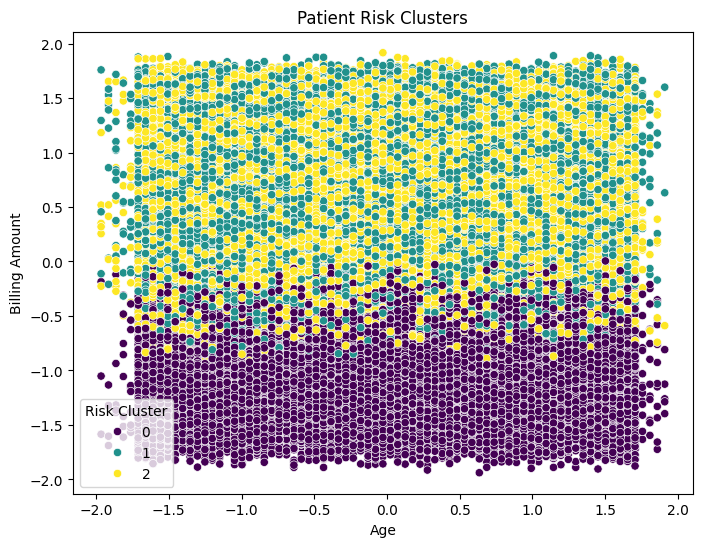


--- Hospital Resource Forecasting (ARIMA) ---


c:\Users\roshan\Desktop\Dissertation\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\roshan\Desktop\Dissertation\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


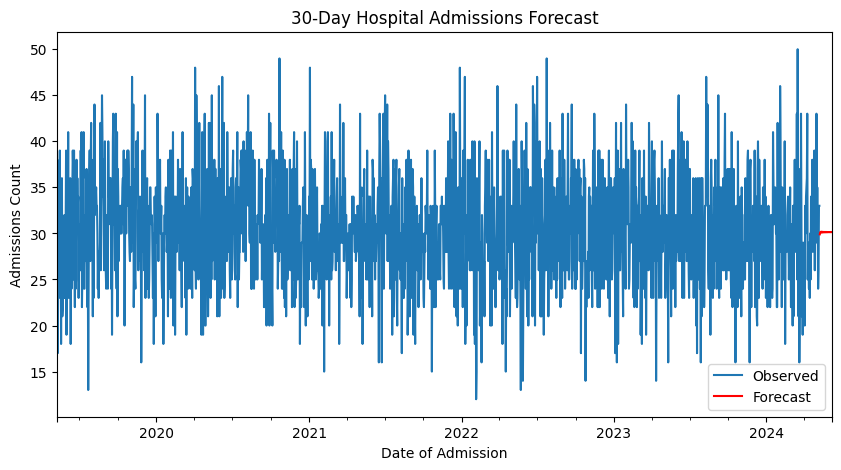

MAE: 4.467349574327432
RMSE: 5.662922822234962


In [1]:
# Install libraries (only needed in Colab)
# !pip install pandas scikit-learn matplotlib seaborn shap statsmodels
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Load your dataset
df = pd.read_csv('healthcare_ds.csv')  # Replace with your file path

# --- Step 1: Preprocessing (as per PDF) ---
# Use only the essential columns
df = df[['Age', 'Gender', 'Blood Type', 'Medical Condition', 'Admission Type',
         'Test Results', 'Medication', 'Billing Amount', 'Date of Admission', 'Discharge Date']]

# Convert date columns
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'], errors='coerce')
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], errors='coerce')

# Create Length of Stay
df['Length of Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

# Drop rows with missing data
df.dropna(inplace=True)

# Encode categorical features
le = LabelEncoder()
for col in ['Gender', 'Blood Type', 'Admission Type', 'Test Results', 'Medication', 'Medical Condition']:
    df[col] = le.fit_transform(df[col])

# Feature Scaling
scaler = StandardScaler()
df[['Age', 'Billing Amount', 'Length of Stay']] = scaler.fit_transform(df[['Age', 'Billing Amount', 'Length of Stay']])

# ------------------ 1. Disease Prediction ------------------
print("\n--- Disease Prediction (Random Forest) ---")
X = df.drop(['Medical Condition', 'Date of Admission', 'Discharge Date'], axis=1)
y = df['Medical Condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# AUC-ROC Score (multi-class average)
y_proba = rf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print("AUC-ROC Score:", roc_auc)

# ------------------ 2. Model Explainability (SHAP) ------------------
# print("\n--- SHAP Explainability ---")
# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test, plot_type="bar")

# ------------------ 3. Patient Risk Clustering (K-Means) ------------------
print("\n--- Patient Risk Clustering (K-Means) ---")
cluster_data = df[['Age', 'Billing Amount', 'Length of Stay']]
kmeans = KMeans(n_clusters=3, random_state=42)
df['Risk Cluster'] = kmeans.fit_predict(cluster_data)

# Cluster Evaluation
sil_score = silhouette_score(cluster_data, df['Risk Cluster'])
db_score = davies_bouldin_score(cluster_data, df['Risk Cluster'])
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")

# Visualize Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Age', y='Billing Amount', hue='Risk Cluster', palette='viridis')
plt.title('Patient Risk Clusters')
plt.show()

# ------------------ 4. Hospital Resource Forecasting (ARIMA) ------------------
print("\n--- Hospital Resource Forecasting (ARIMA) ---")
admissions = df.groupby('Date of Admission').size().asfreq('D').fillna(0)

# Fit ARIMA model
model = ARIMA(admissions, order=(3, 1, 2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

# Plot Forecast
plt.figure(figsize=(10, 5))
admissions.plot(label='Observed')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.title('30-Day Hospital Admissions Forecast')
plt.ylabel('Admissions Count')
plt.show()

# Evaluate ARIMA Forecast (optional)
from sklearn.metrics import mean_absolute_error, mean_squared_error
predicted = model_fit.predict(start=len(admissions)-30, end=len(admissions)-1, dynamic=False)
true = admissions[-30:]
print("MAE:", mean_absolute_error(true, predicted))
print("RMSE:", np.sqrt(mean_squared_error(true, predicted)))
